# Рекомендательная система фильмов на основе средневзвешенного рейтинга и Cosine TFIDF описаний
## Используется датасет IMDB, который можно найти по [ссылке в kaggle](https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/data) с соответствующим описанием

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

import warnings
warnings.simplefilter('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
movies_df = pd. read_csv('drive/MyDrive/data/movies_metadata.csv')
movies_df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [4]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  4494 non-null   object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [8]:
# заполним пропущенные значения в жанрах пустыми списками
movies_df['genres'] = movies_df['genres'].fillna('[]')

# Использовуем literal_eval для безопасного считывания строкового представления списка
movies_df['genres'] = movies_df['genres'].apply(literal_eval)

# извлекаем поля 'name' из каждого словаря в списке
movies_df['genres'] = movies_df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0


In [9]:
C = movies_df['vote_average'].mean()
C

5.618207215134185

In [10]:
m = movies_df['vote_count'].quantile(0.95)
m

434.0

In [11]:
movies_df['year'] = pd.to_datetime(movies_df['release_date'], errors='coerce').dt.year

movies_df['year'] = movies_df['year'].astype('Int64')

print(movies_df['year'].describe())

count        45376.0
mean     1991.881193
std         24.05536
min           1874.0
25%           1978.0
50%           2001.0
75%           2010.0
max           2020.0
Name: year, dtype: Float64


## Сначала будем строить рекомендации на основе средневзвешенного рейтинга используя известную формулу
- метод полезен, когда никакой информации о пользователе нет, что как раз происходит в данном проекте
- данный подход использовался в IMDB

In [12]:
qualified_movies = movies_df[(movies_df['vote_count'] >= m)][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]

qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')
qualified_movies['year']= qualified_movies['year'].astype('int')
qualified_movies.shape

(2274, 6)

In [13]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [14]:
qualified_movies['weighted_rating'] = qualified_movies.apply(weighted_rating, axis=1)

In [15]:
qualified_movies = qualified_movies.sort_values('weighted_rating', ascending=False).head(250)
qualified_movies.head(10)

,title,year,vote_count,vote_average,popularity,genres,weighted_rating
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.928755
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.918626
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.911049
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.897775
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.889160
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.886457
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.882427
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.880635
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.879536
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.871988


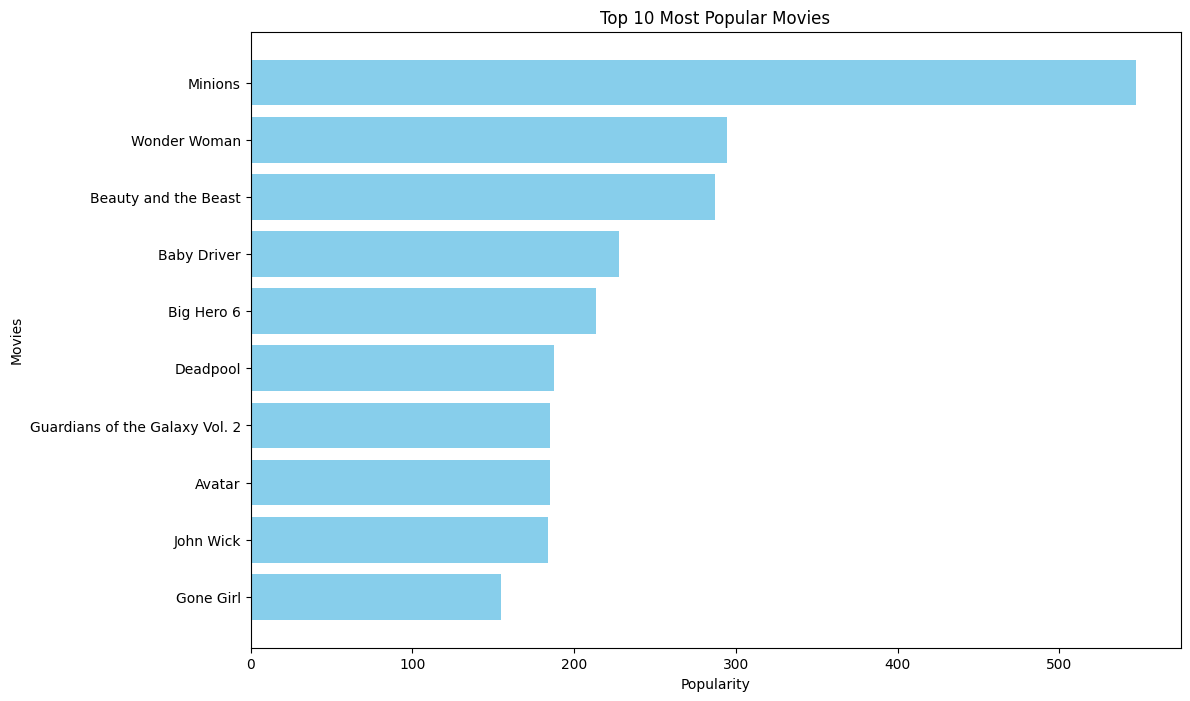

In [16]:
import matplotlib.pyplot as plt

movies_df['popularity'] = pd.to_numeric(movies_df['popularity'], errors='coerce')

movies_df = movies_df.dropna(subset=['popularity'])

pop = movies_df.sort_values('popularity', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(pop['title'].head(10), pop['popularity'].head(10), align='center', color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.ylabel("Movies")
plt.title("Top 10 Most Popular Movies")
plt.show()

In [17]:
def build_chart(genre, percentile=0.85):
    """
    Построение чартов для опредленного жанра

    Parameters:
        genre (str): жанр, по которому фильтруем.
        percentile (float, optional): Процентное значение для минимального количества голосов. По умолчанию 0.85.

    Returns:
        DataFrame, содержащий самые лучшие фильмы указанного жанра.
    """

    s = movies_df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'genre'
    gen_md = movies_df.drop('genres', axis=1).join(s)

    # Фильтрация фильмов по заданному жанру
    df = gen_md[gen_md['genre'] == genre]

    # Расчет среднего значения голосов
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()

    # Рассчитаем минимальное количество голосов, необходимое для включения в чарт
    m = vote_counts.quantile(percentile)

    # Фильтруем фильмы, прошедшие отбор, по количеству голосов и среднему значению
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')

    # взвешенный рейтинг для каждого фильма
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)

    # Сортируем фильмы на основе взвешенного рейтинга в порядке убывания и выбираем 250 лучших
    qualified = qualified.sort_values('wr', ascending=False).head(250)

    return qualified

In [18]:
build_chart('Romance').head(15)

,title,year,vote_count,vote_average,popularity,wr
10309,Dilwale Dulhania Le Jayenge,1995,661,9,34.457024,8.565285
351,Forrest Gump,1994,8147,8,48.307194,7.971357
876,Vertigo,1958,1162,8,18.208220,7.811667
40251,Your Name.,2016,1030,8,34.461252,7.789489
883,Some Like It Hot,1959,835,8,11.845107,7.745154
1132,Cinema Paradiso,1988,834,8,14.177005,7.744878
19901,Paperman,2012,734,8,7.198633,7.713951
37863,Sing Street,2016,669,8,10.672862,7.689483
882,The Apartment,1960,498,8,11.994281,7.599317
38718,The Handmaiden,2016,453,8,16.727405,7.566166


## Content Based рекомендации

In [20]:
credits = pd.read_csv('drive/MyDrive/data/credits.csv')
keywords = pd.read_csv('drive/MyDrive/data/keywords.csv')
credits.head(3)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


In [21]:
keywords.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [22]:
links_small = pd.read_csv('drive/MyDrive/data/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [23]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
movies_df['id'] = movies_df['id'].astype('int')

In [24]:
movies_df = movies_df.merge(credits, on='id')
movies_df = movies_df.merge(keywords, on='id')

In [25]:
num_unique_movies = movies_df['id'].nunique()
print("Number of unique movies:", num_unique_movies)

Number of unique movies: 45429


In [26]:
movies_df = movies_df[movies_df['id'].isin(links_small)]
movies_df.shape

(9219, 28)

In [27]:
num_unique_movies = movies_df['id'].nunique()
print("Number of unique movies:", num_unique_movies)

Number of unique movies: 9082


In [28]:
movies_df['cast'] = movies_df['cast'].apply(literal_eval)
movies_df['crew'] = movies_df['crew'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)
movies_df['cast_size'] = movies_df['cast'].apply(lambda x: len(x))
movies_df['crew_size'] = movies_df['crew'].apply(lambda x: len(x))

In [29]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [30]:
movies_df['director'] = movies_df['crew'].apply(get_director)

In [31]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",7,4,Howard Deutch
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,False,6.1,34.0,1995,"[{'cast_id': 1, 'character': 'Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",10,10,Forest Whitaker
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,False,5.7,173.0,1995,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",12,7,Charles Shyer


In [32]:
# Преобразование столбца 'cast', чтобы он содержал только имена первых трех членов актерского состава, если они доступны
movies_df['cast'] = movies_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df['cast'] = movies_df['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)

In [33]:
movies_df.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",26,16,Joe Johnston


In [34]:
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
movies_df.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,video,vote_average,vote_count,year,cast,crew,keywords,cast_size,crew_size,director
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,False,7.7,5415.0,1995,"[Tom Hanks, Tim Allen, Don Rickles]","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[jealousy, toy, boy, friendship, friends, riva...",13,106,John Lasseter
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,False,6.9,2413.0,1995,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[board game, disappearance, based on children'...",26,16,Joe Johnston
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,False,6.5,92.0,1995,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[fishing, best friend, duringcreditsstinger, o...",7,4,Howard Deutch


In [35]:
selected_features = ['genres', 'keywords', 'tagline', 'cast', 'director','overview']

# Заменим нулевые значения пустой строкой
for feature in selected_features:
    movies_df[feature] = movies_df[feature].fillna('')

In [36]:
movies_df['cast'] = movies_df['cast'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
movies_df['genres'] = movies_df['genres'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
movies_df['keywords'] = movies_df['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

In [38]:
# комбинируем фичи
combined_features = movies_df['overview'] + ' ' + movies_df['genres'] + ' ' + movies_df['keywords'] + ' ' + movies_df['tagline'] + ' ' +  movies_df['cast'] + ' ' + movies_df['director'] + ' ' + movies_df['director'] + ' ' + movies_df['director']
combined_features.head(3)

,0
0,"Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences. Animation Comedy Family jealousy toy boy friendship friends rivalry boy next door new toy toy comes to life Tom Hanks Tim Allen Don Rickles John Lasseter John Lasseter John Lasseter"
1,"When siblings Judy and Peter discover an enchanted board game that opens the door to a magical world, they unwittingly invite Alan -- an adult who's been trapped inside the game for 26 years -- into their living room. Alan's only hope for freedom is to finish the game, which proves risky as all three find themselves running from giant rhinoceroses, evil monkeys and other terrifying creatures. Adventure Fantasy Family board game disappearance based on children's book new home recluse giant insect Roll the dice and unleash the excitement! Robin Williams Jonathan Hyde Kirsten Dunst Joe Johnston Joe Johnston Joe Johnston"
2,"A family wedding reignites the ancient feud between next-door neighbors and fishing buddies John and Max. Meanwhile, a sultry Italian divorcée opens a restaurant at the local bait shop, alarming the locals who worry she'll scare the fish away. But she's less interested in seafood than she is in cooking up a hot time with Max. Romance Comedy fishing best friend duringcreditsstinger old men Still Yelling. Still Fighting. Still Ready for Love. Walter Matthau Jack Lemmon Ann-Margret Howard Deutch Howard Deutch Howard Deutch"


### Применим TF-IDF и косинусное сходство и составим матрицы

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')

tfidf_matrix = tfidf_vectorizer.fit_transform(combined_features)
print(tfidf_matrix.shape)

(9219, 388222)


In [41]:
# матрица косинусного сходства
cosine_sim = cosine_similarity(tfidf_matrix)
print(cosine_sim)

[[1.00000000e+00 8.63302403e-03 8.93187377e-03 ... 0.00000000e+00
  2.67848032e-03 8.52052114e-03]
 [8.63302403e-03 1.00000000e+00 9.67724990e-03 ... 9.44888682e-04
  8.13461552e-03 2.32082083e-03]
 [8.93187377e-03 9.67724990e-03 1.00000000e+00 ... 1.70443096e-03
  1.22381054e-03 3.05200193e-02]
 ...
 [0.00000000e+00 9.44888682e-04 1.70443096e-03 ... 1.00000000e+00
  3.48124570e-03 0.00000000e+00]
 [2.67848032e-03 8.13461552e-03 1.22381054e-03 ... 3.48124570e-03
  1.00000000e+00 8.69233993e-04]
 [8.52052114e-03 2.32082083e-03 3.05200193e-02 ... 0.00000000e+00
  8.69233993e-04 1.00000000e+00]]


In [42]:
movies_df = movies_df.reset_index()
titles = movies_df['title']
indices = pd.Series(movies_df.index, index=movies_df['title'])

## Строим рекоммендации
Первый наивный алгоритм

In [44]:
import difflib

def get_recommendations(title):
    close_match = difflib.get_close_matches(title, titles)
    print(close_match)
    if not close_match:
        print("No close match found for '{}'.".format(title))
        return

    # Выбор самого похожего названия
    close_title = close_match[0]

    # поиск индекса найденного названия
    idx = indices[close_title]
    # Вычисление косинусного сходства:
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Сортировка фильмов по сходству
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Выбор топ-10 наиболее похожих фильмов
    sim_scores = sim_scores[1:11]

    # Получение индексов топ-10 фильмов
    movie_indices = [i[0] for i in sim_scores]

    return titles.iloc[movie_indices]

user_title = "Terminator"
recommendations = get_recommendations(user_title)
print("Recommendations for '{}': \n{}".format(user_title, recommendations))

['The Terminator', 'Terminator Genisys', 'Traitor']
Recommendations for 'Terminator': 
522             Terminator 2: Judgment Day
344                              True Lies
974                                 Aliens
922                              The Abyss
7488                                Avatar
4347        Piranha Part Two: The Spawning
4739    Terminator 3: Rise of the Machines
8854                    Terminator Genisys
7296                  Terminator Salvation
1376                               Titanic
Name: title, dtype: object


Продвинутый алгоритм с фильтрацией и ранжированием на основе средневзвешанных рейтингов и количества голосов

In [46]:
import difflib

def improved_recommendations(title):

    close_match = difflib.get_close_matches(title, movies_df['title'])
    print(close_match)
    if not close_match:
        print("No close match found for '{}'.".format(title))
        return

    close_title = close_match[0]

    idx = indices[close_title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]

    movies = movies_df.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
    vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(0.60)
    qualified_movies = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
    qualified_movies['vote_count'] = qualified_movies['vote_count'].astype('int')
    qualified_movies['vote_average'] = qualified_movies['vote_average'].astype('int')
    qualified_movies['wr'] = qualified_movies.apply(weighted_rating, axis=1)
    qualified_movies = qualified_movies.sort_values('wr', ascending=False).head(10)
    return qualified_movies

user_title = "iron man"
recommendations = improved_recommendations(user_title)
print("Recommendations for '{}': \n".format(user_title))
recommendations

['Iron Man', 'Iron Man 3', 'Iron Man 2']
Recommendations for 'iron man': 



,title,vote_count,vote_average,year,wr
8872,Captain America: Civil War,7462,7,2016,6.924050
8868,Avengers: Age of Ultron,6908,7,2015,6.918320
8392,Iron Man 3,8951,6,2013,5.982344
7600,Iron Man 2,6969,6,2010,5.977617


In [47]:
import pickle
# Сохранение movies_df
with open('movies_df.pkl', 'wb') as f:
    pickle.dump(movies_df, f)

In [48]:
# Сохранение cosine_sim
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

In [49]:
!cp /content/cosine_sim.pkl /content/drive/MyDrive/